# Direct ATLAS analysis 2.0

Redo the direct ATLAS analysis with the correct assignment of momenta in the fortran dummy_fct.f file to see whether it changes the K-factor and the limits.

Keep the axion mass fixed at 𝑚𝑎=1 MeV and 𝑓𝑎=1 TeV

In [2]:
import awkward as ak
import hist
import numpy as np
import scipy as sp
import pylhe
from mt2 import mt2
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import uncertainties.unumpy as unp
from uncertainties import ufloat
from scipy.optimize import fsolve
import csv 
import pandas as pd

In [3]:
import seaborn as sns
colors = sns.color_palette("colorblind", 8)

In [4]:
lumi = 139*1e3 #fb

## General functions for axion events

In [5]:
def read_sigma_nevents(dirname):
    filename = dirname + dirname.split('/')[-2]+'_tag_1_banner.txt'
    with open(filename,'r') as f:
        data = f.readlines()
    f.close()
    sigma = float(data[-4].split(' ')[-1])
    nevents = float(data[-5].split(' ')[-1])
    return sigma, nevents

In [6]:
def csv_reader(filename):
    output = []
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            output.append(row)
        csvfile.close()

    return output

In [7]:
def read_HEPdata():
    data = csv_reader('./data/HEPData-ins1844425-v1-Figure_11a.csv')
    atlas_data  = []
    atlas_data_err_up = []
    atlas_data_err_down = []
    
    for item in data[10:17]:
        atlas_data.append(float(item[3]))
        atlas_data_err_up.append(float(item[4]))
        atlas_data_err_down.append(abs(float(item[5])))
    
    atlas_data_err = (atlas_data_err_up, atlas_data_err_down)
    return atlas_data, atlas_data_err

In [8]:
def read_HEP_SM():
    data = csv_reader('./data/HEPData-ins1844425-v1-Figure_11a.csv')
    atlas_sm  = []
    atlas_sm_err = []
    
    for item in data[20:27]:
        atlas_sm.append(float(item[3]))
        atlas_sm_err.append(float(item[4]))
    
    return atlas_sm, atlas_sm_err

In [9]:
def mt2_ttbar(arr):
    
    vecL1 = arr.particles.vector[:,-6]   
    vecL2 = arr.particles.vector[:,-3] 
        
    vecB1 = arr.particles.vector[:,-7]   
    vecB2 = arr.particles.vector[:,-4]
        
    massL1 = 0.1 # assume masses for the leptons
    massL2 = 0.1

    pxL1 = vecL1.px
    pyL1 = vecL1.py

    pxL2 = vecL2.px
    pyL2 = vecL2.py
    
    vecMiss = -(vecL1 + vecL2 + vecB1 + vecB2)

    pmiss_x = vecMiss.px
    pmiss_y = vecMiss.py

    mmiss1 = 0 # masses of the neutrinos or other invisible components, set to zero
    mmiss2 = 0
    
    val = mt2(
    massL1, pxL1, pyL1,  # Visible 1: mass, px, py
    massL2, pxL2, pyL2,  # Visible 2: mass, px, py
    pmiss_x, pmiss_y,  # Missing transverse momentum: x, y
    mmiss1, mmiss2)  # Invisible 1 mass, invisible 2 mass

    return val

In [10]:
def calculate_mt2(dirname):
    
    sigma, nevents = read_sigma_nevents(dirname)
    ww = sigma*lumi/nevents
    
    pylhe.register_awkward()
    filename = dirname + 'unweighted_events.lhe.gz'
    arr = pylhe.to_awkward(pylhe.read_lhe_with_attributes(filename))
    val = mt2_ttbar(arr)
    
    return (val, ww)

In [11]:
def calculate_Etmiss(dirname):
    
    pylhe.register_awkward()
    filename = dirname + 'unweighted_events.lhe.gz'
    arr = pylhe.to_awkward(pylhe.read_lhe_with_attributes(filename))
    
    vecL1 = arr.particles.vector[:,-6]   
    vecL2 = arr.particles.vector[:,-3] 
        
    vecB1 = arr.particles.vector[:,-7]   
    vecB2 = arr.particles.vector[:,-4]
    
    vecMiss = -(vecL1 + vecL2 + vecB1 + vecB2)
    
    return vecMiss.Et

In [12]:
def calculate_ECM(dirname):
    
    pylhe.register_awkward()
    filename = dirname + 'unweighted_events.lhe.gz'
    arr = pylhe.to_awkward(pylhe.read_lhe_with_attributes(filename))
    
    vecL1 = arr.particles.vector[:,-6]   
    vecL2 = arr.particles.vector[:,-3] 
        
    vecB1 = arr.particles.vector[:,-7]   
    vecB2 = arr.particles.vector[:,-4]
    
    vecNu1 = arr.particles.vector[:,-5]
    vecNu2 = arr.particles.vector[:,-2]
    
    vecAx = arr.particles.vector[:,-1]
    
    vecAll = (vecL1 + vecL2 + vecB1 + vecB2 + vecNu1 + vecNu2 + vecAx)
    
    return vecAll.E

In [13]:
def calculate_binheight(hist):
    Nbins = len(atlas_bins)-1
    binheight = np.zeros(Nbins)
        
    for i in range(Nbins):
        binheight[i] = hist[i]
    
    return binheight

In [14]:
def generate_hist(mt2,ww):
    axis0 = hist.axis.Variable(atlas_bins, name="mt2");
    hist0 = hist.Hist(axis0);
    hist0.fill(mt2=mt2, weight=ww);
    return hist0

In [15]:
# get the binheight from the distributions normalised with the cross section and lumi
# get the Nbin from the unnormalised distribution, i.e. dividing by ww

def calculate_yerr(hist, ww):
    Nbins = len(atlas_bins)-1
    binheight = np.zeros(Nbins)
    Nbin = np.zeros(Nbins)
    y_err = np.zeros(Nbins)
    
    for i in range(Nbins):
        binheight[i] = hist[i]
        Nbin[i] = hist[i]/ww
    
        if Nbin[i] > 0:
            y_err[i] = binheight[i]/np.sqrt(Nbin[i])
    
    binheight_err = unp.uarray(binheight, y_err)* Kfactor
    #binheight_err = unp.uarray(binheight, y_err)* Kfactor.nominal_value
    #binheight = unp.nominal_values(binheight_err)
    #y_err = unp.std_devs(binheight_err)
    
    return(binheight_err)

## Experimental data and K-factor

In [16]:
atlas_bins = [100.0,110.0, 120.0, 140.0, 160.0, 180.0, 220.0, 280.0]

In [17]:
Kfactor = ufloat(0.4781,0.0761)

In [18]:
width = 0.05
bincenters = [105,115,130, 150, 170, 200, 250]

In [19]:
atlas_data, atlas_data_error = read_HEPdata()

In [20]:
atlas_sm, atlas_sm_error = read_HEP_SM()
binheight_sm = atlas_sm

In [21]:
print(atlas_sm)
print(atlas_sm_error)

[50.3, 21.7, 16.2, 5.1, 2.8, 3.2, 3.1]
[5.9, 4.3, 3.2, 0.7, 0.4, 0.4, 0.6]


## Read in data and calculate mt2 - for plot

In [22]:
dir_ttbarax_c05 = os.path.expanduser('~/Documents/MadGraph/ppttaxleptonic_offshell/Events/run_11/')
dir_ttbarax_c1 = os.path.expanduser('~/Documents/MadGraph/ppttaxleptonic_offshell/Events/run_12/')
dir_ttbarax_c2 = os.path.expanduser('~/Documents/MadGraph/ppttaxleptonic_offshell/Events/run_13/')

In [23]:
mt2_c05, ww_c05 = calculate_mt2(dir_ttbarax_c05)
mt2_c1, ww_c1 = calculate_mt2(dir_ttbarax_c1)
mt2_c2, ww_c2 = calculate_mt2(dir_ttbarax_c2)

/var/folders/d0/vjgg68h93_q2fcyzx7cftx_h0000gn/T/ipykernel_93361/834288396.py:6: DeprecationWarning: pylhe.awkward.register_awkward is deprecated as of pylhe v0.6.0 and will be removed in pylhe v0.8.0. Please remove use of pylhe.awkward.register_awkward in favor of automatic registration.
  pylhe.register_awkward()


In [24]:
hist_c05 = generate_hist(mt2_c05, ww_c05*Kfactor.nominal_value)
hist_c1 = generate_hist(mt2_c1, ww_c1*Kfactor.nominal_value)
hist_c2 = generate_hist(mt2_c2, ww_c2*Kfactor.nominal_value)

In [25]:
binheight_c05 = calculate_binheight(hist_c05)
binheight_c1 = calculate_binheight(hist_c1)
binheight_c2 = calculate_binheight(hist_c2)

In [26]:
bs_c05 = binheight_c05 + binheight_sm
bs_c1 = binheight_c1 + binheight_sm
bs_c2 = binheight_c2 + binheight_sm

In [27]:
axion_data = (bs_c05, bs_c1, bs_c2)

In [28]:
#Create arrays for step plot
atlas_data_plot = np.concatenate([atlas_data, [atlas_data[-1]]])
atlas_error_plot_down = np.concatenate([atlas_data_error[1], [atlas_data_error[1][-1]]])
atlas_error_plot_up = np.concatenate([atlas_data_error[0], [atlas_data_error[0][-1]]])

In [29]:
def index_function(i):
    return 0.25*((i+0.5)**2+1.75)

/var/folders/d0/vjgg68h93_q2fcyzx7cftx_h0000gn/T/ipykernel_93361/3234638629.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


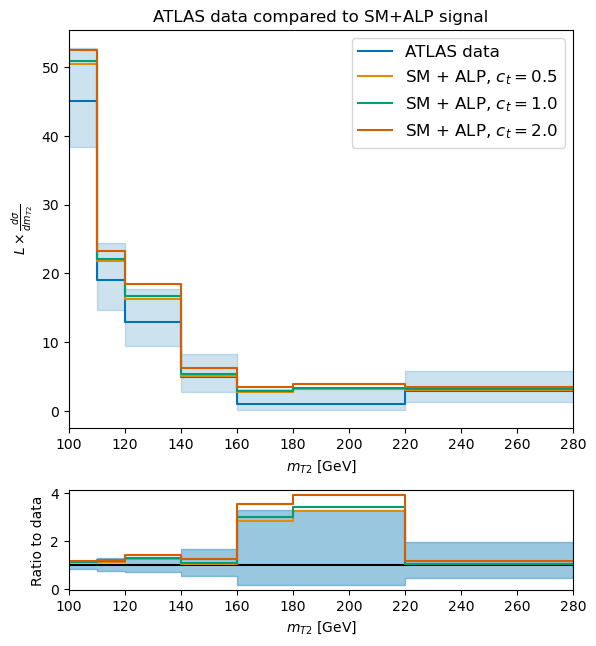

In [30]:
#Create figure and axes
fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(2, 1, height_ratios=(4, 1), left=0.14, right=0.86, bottom=0.1, top=0.9, wspace=0.55, hspace=0.25)
    
ax = fig.add_subplot(gs[0, 0])
ax_ratio = fig.add_subplot(gs[1, 0], sharex=ax)

#Plot data
ax.step(atlas_bins, atlas_data_plot, where='post',label='ATLAS data', color=colors[0])
ax.fill_between(atlas_bins, atlas_data_plot-atlas_error_plot_down, atlas_data_plot+atlas_error_plot_up, color=colors[0],step='post', alpha=0.2)
ax.set_title('ATLAS data compared to SM+ALP signal')
#ax.set_yscale('log')
ax.set_xlim([100,280]);
ax.set_xlabel(r'$m_{T2}$ [GeV]')
ax.set_ylabel(r'$L \times\frac{d \sigma}{d m_{T2}}$')

ax_ratio.set_xlabel(r'$m_{T2}$ [GeV]')
ax_ratio.set_ylabel('Ratio to data')
ax_ratio.hlines(xmin=100, xmax=280, y=1.0,color='black')

data_ratio_unc_down = np.divide(atlas_error_plot_down, atlas_data_plot)
data_ratio_unc_up = np.divide(atlas_error_plot_up, atlas_data_plot)
ax_ratio.fill_between(atlas_bins, 1-data_ratio_unc_down, 1+data_ratio_unc_up, color=colors[0],step='post', alpha=0.4)

for ind in range(3):

        #Create arrays for step plot
        axion_data_plot = np.concatenate([axion_data[ind], [axion_data[ind][-1]]])

        #Create ratio arrays
        axion_data_ratio = np.divide(axion_data_plot,atlas_data_plot)
        
        ax.step(atlas_bins, axion_data_plot, where='post',label=r'SM + ALP, $c_{t} = $'+str(index_function(ind)), color=colors[ind+1])
        ax_ratio.step(atlas_bins, axion_data_ratio, where='post',color=colors[ind+1])
        
plt.rc('axes', labelsize=14)
ax.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1));
plt.tight_layout()
#plt.savefig('plots/axion_direct_ATLAS.pdf', bbox_inches="tight")
plt.show()  

## More events for 𝑐=1 for exclusion limits


In [31]:
dir_ttbarax_c = os.path.expanduser('~/Documents/MadGraph/ppttaxleptonic_offshell/Events/run_10/')

In [32]:
mt2_c, ww_c = calculate_mt2(dir_ttbarax_c)

/var/folders/d0/vjgg68h93_q2fcyzx7cftx_h0000gn/T/ipykernel_93361/834288396.py:6: DeprecationWarning: pylhe.awkward.register_awkward is deprecated as of pylhe v0.6.0 and will be removed in pylhe v0.8.0. Please remove use of pylhe.awkward.register_awkward in favor of automatic registration.
  pylhe.register_awkward()


In [33]:
hist_c = generate_hist(mt2_c, ww_c*Kfactor.nominal_value)

In [34]:
#binheight_c = calculate_yerr(hist_c/Kfactor.nominal_value, ww_c)
binheight_c = calculate_binheight(hist_c)

In [35]:
print(binheight_c)
print(binheight_c/Kfactor.nominal_value)

[0.56240718 0.41554095 0.55799887 0.33642344 0.1981418  0.19930188
 0.08561396]
[1.17633796 0.86915069 1.16711749 0.70366751 0.4144359  0.41686234
 0.17907125]


In [36]:
bs_c = binheight_c + binheight_sm

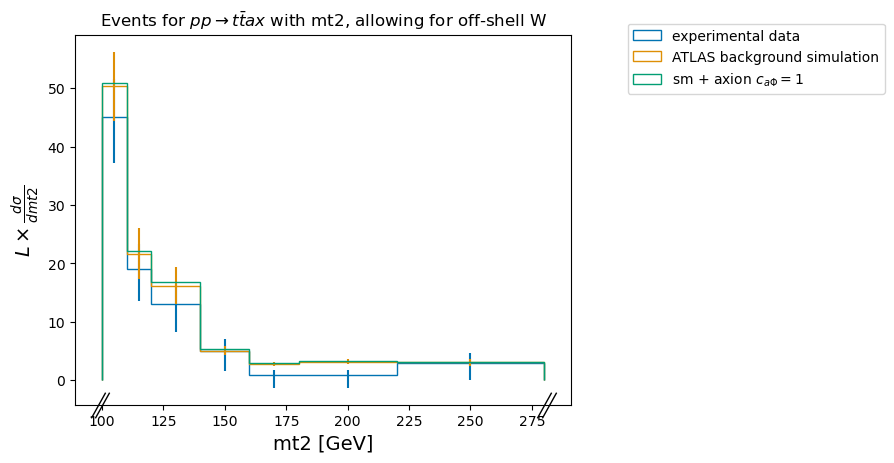

In [37]:
artists1 = hist_c.plot1d(color = 'none');

# data
plt.hist(atlas_bins[:-1], atlas_bins, weights=atlas_data, color=colors[0], histtype = 'step', label = 'experimental data')
plt.bar(bincenters, atlas_data, width=width, color='none', yerr = atlas_data_error, log = False, error_kw=dict(ecolor=colors[0]))

# sm background
plt.hist(atlas_bins[:-1], atlas_bins, weights=atlas_sm, color=colors[1], histtype = 'step', label = 'ATLAS background simulation')
plt.bar(bincenters, atlas_sm, width=width, color='none', yerr = atlas_sm_error, log = False, error_kw=dict(ecolor=colors[1]))

# sm + axion signal
plt.hist(atlas_bins[:-1], atlas_bins, weights=unp.nominal_values(bs_c), color=colors[2], histtype = 'step', label = 'sm + axion $c_{a\Phi} = 1$')
plt.bar(bincenters, unp.nominal_values(bs_c), width=width, color='none', yerr = unp.std_devs(bs_c), log = False, error_kw=dict(ecolor=colors[2]))

ax = artists1[0].stairs.axes;
ax.set_yscale("linear");
ax.set_xlabel("mt2 [GeV]");
ax.set_ylabel(r"$L \times \frac{d\sigma}{d mt2}$");
ax.set_title(r'Events for $ p p \rightarrow t \bar{t} ax$ with mt2, allowing for off-shell W');

plt.rc('axes', labelsize=20)
plt.legend(bbox_to_anchor=(1.1, 1.05))
#plt.savefig("./plots/ttbarax_offshell_c1_linear.png", bbox_inches="tight")

### Correlations between $m_{T2}$ and $E_T^{miss}$ and $E_{CM}$

In [38]:
Etmiss_c = calculate_Etmiss(dir_ttbarax_c)

/var/folders/d0/vjgg68h93_q2fcyzx7cftx_h0000gn/T/ipykernel_93361/11522123.py:3: DeprecationWarning: pylhe.awkward.register_awkward is deprecated as of pylhe v0.6.0 and will be removed in pylhe v0.8.0. Please remove use of pylhe.awkward.register_awkward in favor of automatic registration.
  pylhe.register_awkward()


(ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7ff1cd0c15b0>, cbar=None, text=[]),
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff1dc9bbee0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)],
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff169f5d190>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)])

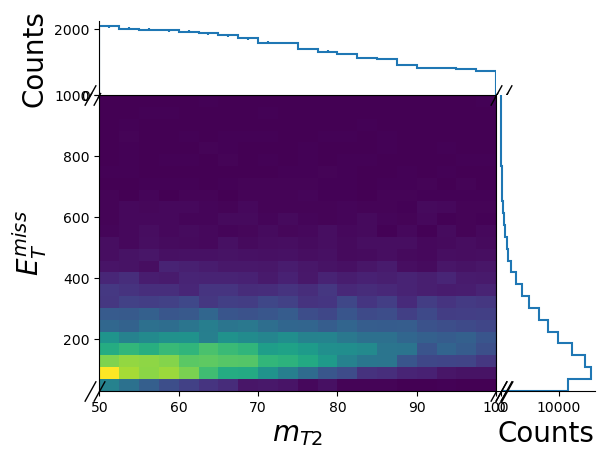

In [39]:
hist_mt2Etmiss = hist.Hist.new.Reg(bins = 20, start = 50, stop = 100, name="mt2", label = r"$m_{T2}$").Reg(bins=25, start=30, stop=1000, name="Etmiss", label = r"$E_T^{miss}$").Int64();
hist_mt2Etmiss.fill(mt2=mt2_c, Etmiss=Etmiss_c);
hist_mt2Etmiss.plot2d_full()
#plt.savefig('plots/atlas_axion_correlation_mt2_Etmiss.pdf', bbox_inches="tight")

In [40]:
ECM_c = calculate_ECM(dir_ttbarax_c)

/var/folders/d0/vjgg68h93_q2fcyzx7cftx_h0000gn/T/ipykernel_93361/3881480751.py:3: DeprecationWarning: pylhe.awkward.register_awkward is deprecated as of pylhe v0.6.0 and will be removed in pylhe v0.8.0. Please remove use of pylhe.awkward.register_awkward in favor of automatic registration.
  pylhe.register_awkward()


(ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7ff1bd9e1dc0>, cbar=None, text=[]),
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff1bd80d3d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)],
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff1bc938820>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)])

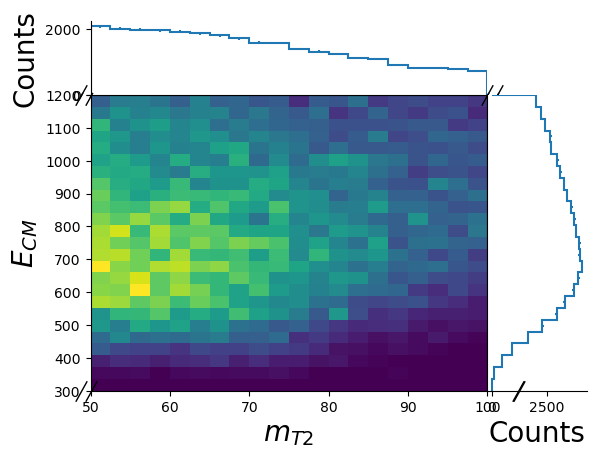

In [41]:
hist_mt2ECM = hist.Hist.new.Reg(bins = 20, start = 50, stop = 100, name="mt2", label = r"$m_{T2}$").Reg(bins=25, start=300, stop=1200, name="ECM", label = r"$E_{CM}$").Int64();
hist_mt2ECM.fill(mt2=mt2_c, ECM=ECM_c);
hist_mt2ECM.plot2d_full()
#plt.savefig('plots/atlas_axion_correlation_mt2_ECM.pdf', bbox_inches="tight")

### select events with $E_T^{miss} > 1000$ GeV

In [42]:
val_Etmiss = (Etmiss_c > 1000)

In [43]:
print(np.count_nonzero(val_Etmiss))

183


In [44]:
mt2_c_Etmisscut = mt2_c[val_Etmiss]

In [45]:
print(len(mt2_c_Etmisscut))

183


In [46]:
atlas_bins_prime = [80, 90 ,100.0,110.0, 120.0, 140.0, 160.0, 180.0, 220.0, 280.0]

In [47]:
#hist_c_Etmisscut = generate_hist(mt2_c_Etmisscut, ww_c*Kfactor.nominal_value)

axis_c_Etmisscut = hist.axis.Variable(atlas_bins_prime, name="mt2");
hist_c_Etmisscut = hist.Hist(axis_c_Etmisscut);
hist_c_Etmisscut.fill(mt2=mt2_c_Etmisscut, weight=1);

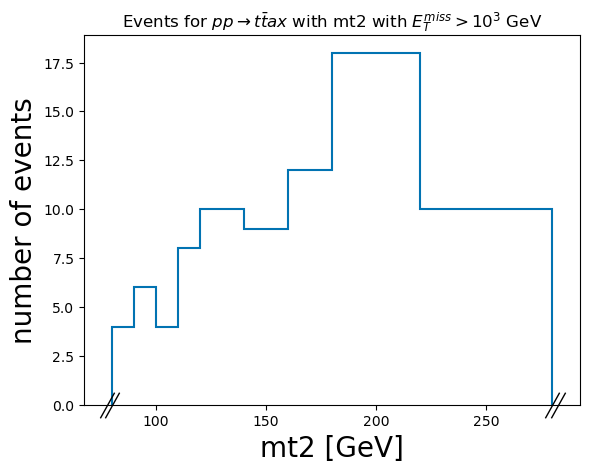

In [48]:
artists1 = hist_c_Etmisscut.plot1d(color = colors[0]);

ax = artists1[0].stairs.axes;
ax.set_yscale("linear");
ax.set_xlabel("mt2 [GeV]");
ax.set_ylabel(r"number of events");
ax.set_title(r'Events for $ p p \rightarrow t \bar{t} ax$ with mt2 with $E_T^{miss} > 10^3$ GeV');

plt.rc('axes', labelsize=20)
plt.savefig('plots/atlas_axion_mt2_Etmiss1000.pdf', bbox_inches="tight")
#plt.legend(bbox_to_anchor=(1.1, 1.05))

### Select events with $m_{T2} > 110$ GeV

In [49]:
val_mt2 = (mt2_c > 110)

In [50]:
ECM_mt2cut = ECM_c[val_mt2]

In [51]:
#hist_c_Etmisscut = generate_hist(mt2_c_Etmisscut, ww_c*Kfactor.nominal_value)

axis_c_ECMcut = hist.axis.Regular(30,400,2510, name="ECM");
hist_c_ECMcut = hist.Hist(axis_c_ECMcut);
hist_c_ECMcut.fill(ECM=ECM_mt2cut, weight=1);

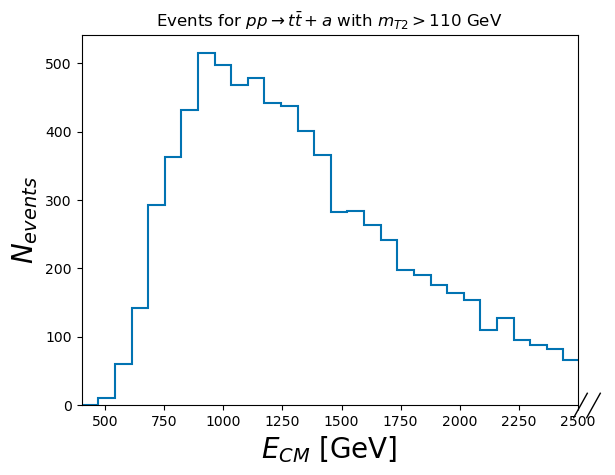

In [52]:
artists1 = hist_c_ECMcut.plot1d(color = colors[0]);

ax = artists1[0].stairs.axes;
ax.set_yscale("linear");
ax.set_xlabel(r"$E_{CM}$ [GeV]");
ax.set_xlim(400,2500)
ax.set_ylabel(r"$N_{events}$");
ax.set_title(r'Events for $ p p \rightarrow t \bar{t} + a$ with $m_{T2} > 110$ GeV');

plt.rc('axes', labelsize=20)
plt.savefig('plots/atlas_axion_ECM_mt2_110.pdf', bbox_inches="tight")
#plt.legend(bbox_to_anchor=(1.1, 1.05))

(ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7ff1cd151790>, cbar=None, text=[]),
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff1cd135580>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)],
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff18951c3d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)])

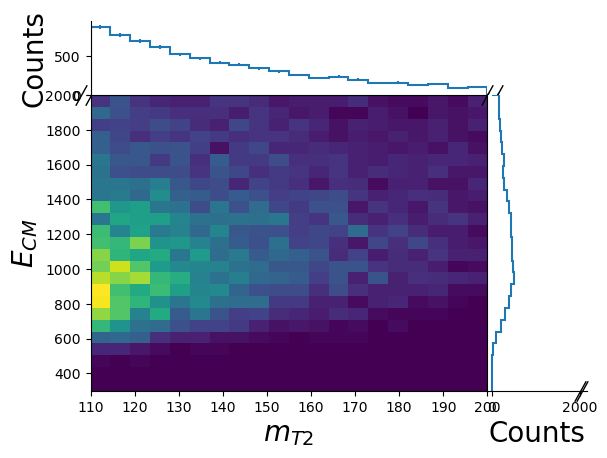

In [53]:
hist_mt2ECMcut = hist.Hist.new.Reg(bins = 20, start = 110, stop = 200, name="mt2", label = r"$m_{T2}$").Reg(bins=25, start=300, stop=2000, name="ECM", label = r"$E_{CM}$").Int64();
hist_mt2ECMcut.fill(mt2=mt2_c[val_mt2], ECM=ECM_mt2cut);
hist_mt2ECMcut.plot2d_full()
#plt.savefig('plots/atlas_axion_correlation_ECM_mt2_110.pdf', bbox_inches="tight")

## Poisson likelihood

In [54]:
def L(c,s,b,n):
    L = 1;
    for k in range(len(atlas_bins)-1):
        L*= np.exp(-(c**2*s[k]+b[k]))*(c**2*s[k]+b[k])**n[k]/np.math.factorial(n[k])
    return L

In [55]:
def L_data(c):
    return L(c,unp.nominal_values(binheight_c),atlas_sm, atlas_data)

In [56]:
L_data(1)

/var/folders/d0/vjgg68h93_q2fcyzx7cftx_h0000gn/T/ipykernel_93361/2897251588.py:4: DeprecationWarning: Using factorial() with floats is deprecated
  L*= np.exp(-(c**2*s[k]+b[k]))*(c**2*s[k]+b[k])**n[k]/np.math.factorial(n[k])


1.3714084859849948e-07

/var/folders/d0/vjgg68h93_q2fcyzx7cftx_h0000gn/T/ipykernel_93361/2897251588.py:4: DeprecationWarning: Using factorial() with floats is deprecated
  L*= np.exp(-(c**2*s[k]+b[k]))*(c**2*s[k]+b[k])**n[k]/np.math.factorial(n[k])


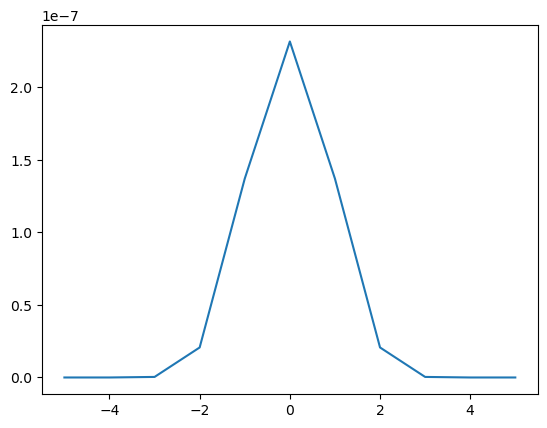

In [57]:
c_data = np.arange(-5,6,1)
plt.plot(c_data, L_data(c_data))

So, unsurprisingly, the likelihood is maximal for c=0.

In [58]:
def Q(c):
    return -2*np.log((L_data(c)/L_data(0)).astype('float64'))

/var/folders/d0/vjgg68h93_q2fcyzx7cftx_h0000gn/T/ipykernel_93361/2897251588.py:4: DeprecationWarning: Using factorial() with floats is deprecated
  L*= np.exp(-(c**2*s[k]+b[k]))*(c**2*s[k]+b[k])**n[k]/np.math.factorial(n[k])


Text(0, 0.5, '$Q(c_t)$')

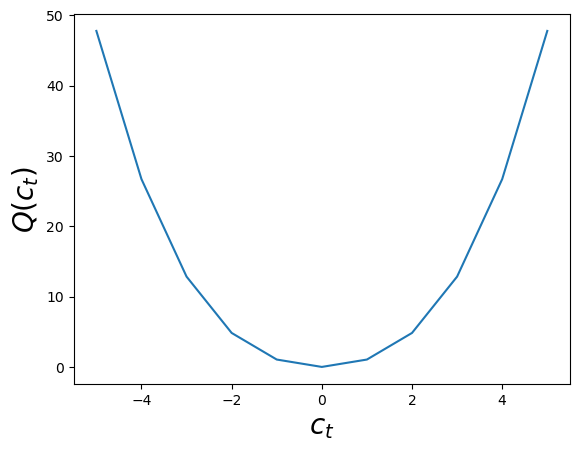

In [59]:
plt.plot(c_data, Q(c_data))
plt.xlabel('$c_t$')
plt.ylabel('$Q(c_t)$')

The distribution of the test statistic is a $\chi^2$ distribution with 1 dof:

$f(Q_c|c) = \frac{1}{\sqrt{2\pi}\sqrt{Q_c}} e^{-\frac{Q_c}{2}}$.

Then the CDF for $Q_C$ reads

$F(Q_c|c) = 2 \Phi(\sqrt{Q_c}) - 1$

with $\Phi$ the CDF of a standard Gaussian. 
The p-value follows from

$p_c = 1- F(Q_c|c) = 2(1- \Phi(\sqrt{Q_c}))$.

In the first step we will solve $p_c = 0.05$ for $Q_c = Q_c^*$ and in a second step $Q_c = Q_c^*$ for c. 

In [60]:
def qCDF(q):
    return 2*sp.stats.norm.cdf(np.sqrt(q))-1

In [61]:
def p_value(q):
    return 2*(1-sp.stats.norm.cdf(np.sqrt(q)))-0.05

1.) Solve $p_c  = 0.05$ for $Q_c$

In [62]:
Q_up = float(fsolve(p_value, 1))

In [63]:
print(Q_up)

3.8414588206941214


Text(0, 0.5, '$F(Q_c|c)$')

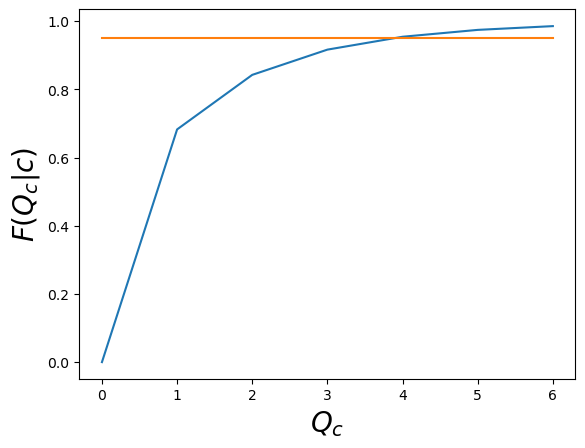

In [64]:
# graphically:
q_data = np.arange(0,7,1)
plt.plot(q_data, qCDF(q_data))
plt.plot(q_data, np.full(len(q_data), 0.95))
plt.xlabel('$Q_c$')
plt.ylabel('$F(Q_c|c)$')
#plt.plot(x_data, sp.stats.norm.cdf(x_data))

2.) Solve $Q_c = Q_{up}$ for $c$

In [65]:
def solve_Q(c):
    return Q(c) - Q_up

In [66]:
c_up = float(fsolve(solve_Q,1))

/var/folders/d0/vjgg68h93_q2fcyzx7cftx_h0000gn/T/ipykernel_93361/2897251588.py:4: DeprecationWarning: Using factorial() with floats is deprecated
  L*= np.exp(-(c**2*s[k]+b[k]))*(c**2*s[k]+b[k])**n[k]/np.math.factorial(n[k])


In [67]:
print(c_up)

1.8105479536492073


## Violin plots

In [68]:
# valbinL_pT, valbinL_Mtt: output from pylhe vectors, the ones we give to the histogram function

In [69]:
print(mt2_c)
print(ECM_c)

[14.9, 9.87, 14.4, 0.22, 76.8, 109, 82.1, ... 0.23, 4.25, 64.5, 90, 71.4, 116, 36.8]
[994, 807, 983, 696, 1.58e+03, ... 1.32e+03, 1.16e+03, 1.09e+03, 1.84e+03, 884]


In [70]:
val_mt2 = (mt2_c > 100)&(mt2_c < 280)
mt2_cut = mt2_c[val_mt2]
ECM_cut = ECM_c[val_mt2]

In [71]:
# sort mt2 and ECM according to mt2

In [72]:
a = np.array((mt2_cut,ECM_cut))

In [73]:
(valbinL_Mtt, valbinL_ECM) = a[:, a[0, :].argsort()]

In [74]:
print(valbinL_Mtt)
print(valbinL_ECM)

[100.00255681 100.00730039 100.00802753 ... 277.59811642 278.18062166
 279.06770641]
[ 916.92813329 1181.27416062 1808.78014359 ... 1531.13082419 1244.91588625
 2466.73403818]


In [75]:
atlas_bins = [100.0,110.0, 120.0, 140.0, 160.0, 180.0, 220.0, 280.0]
bin_labels = ["100-110", "110-120", "120-140", "140-160", "160-180", "180-220", "220-280"]

In [76]:
# go over all events and determine the Mt2 bin they fall into.
axis_mt2 = hist.axis.Variable(atlas_bins, name="mt2");
hist_mt2 = hist.Hist(axis_mt2);
hist_mt2.fill(mt2=valbinL_Mtt);

def check_bin(mt2):
    index = np.digitize([mt2],atlas_bins)[0]
    return index



binname = []
for i in range(np.size(valbinL_ECM)):
    binname.append(bin_labels[check_bin(valbinL_Mtt[i])-1])
    #binname.append(check_bin(valbinL_Mtt[i]))
    
#print(binname)


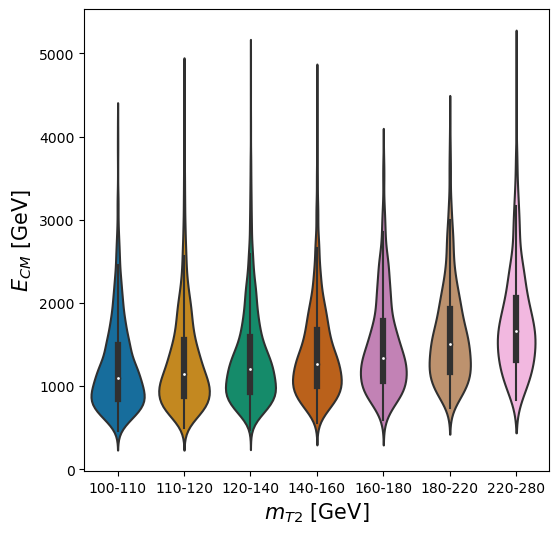

In [90]:
df = pd.DataFrame({r'$m_{T2}$ [GeV]':binname, 'mt2':valbinL_Mtt, r'$E_{CM}$ [GeV]':valbinL_ECM})
#plt.figure()
params = {'figure.figsize': (6, 6),
         'axes.labelsize': '15',
         'xtick.labelsize':'10',
         'ytick.labelsize':'10'}
plt.rcParams.update(params)
#plt.figure(figsize=(6,6))
#ax.axes.label.set_size(16)
sns.violinplot(data=df, y=r"$E_{CM}$ [GeV]", x=r'$m_{T2}$ [GeV]',palette=sns.color_palette('colorblind'))
#plt.title(r'ECM vs mT2 for direct search $t\bar{t} +a$')
#plt.label
plt.savefig('plots/ECM_mt2_violin_direct.pdf', bbox_inches="tight")

### with MT2 cut and equidistant bins

In [196]:
val_mt2 = (mt2_c > 110)

In [197]:
ECM_mt2cut = ECM_c[val_mt2]

In [199]:
b = np.array((mt2_c[val_mt2],ECM_mt2cut))

In [200]:
(cutbin_Mtt, cutbin_ECM) = b[:, b[0, :].argsort()]

In [227]:
bin_num = 10
bin_min = min(cutbin_Mtt)
bin_max = max(cutbin_Mtt)
bins = bin_min+(bin_max-bin_min)/bin_num*np.arange(bin_num+1)
bins[0]=bins[0]-0.001
bins[-1]=bins[-1]+0.001

In [228]:
print(bin_max)

588.1848261817089


In [229]:
print(bins)

[110.00108564 157.82035969 205.63863375 253.4569078  301.27518186
 349.09345591 396.91172996 444.73000402 492.54827807 540.36655213
 588.18582618]


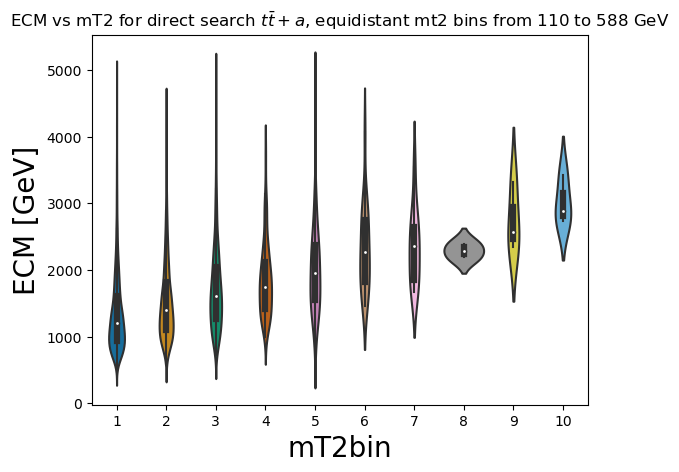

In [234]:
df = pd.DataFrame({'mT2bin':binname, 'mt2':cutbin_Mtt, 'ECM [GeV]':cutbin_ECM})
plt.figure()
sns.violinplot(data=df, y="ECM [GeV]", x='mT2bin',palette=sns.color_palette('colorblind'))
plt.title(r'ECM vs mT2 for direct search $t\bar{t} +a$, equidistant mt2 bins from 110 to 588 GeV')
plt.savefig('plots/ECM_mt2_violin_direct_equidistant.pdf', bbox_inches="tight")